<a href="https://colab.research.google.com/github/Remi-Boutin/DL_project_ENSAE/blob/master/Project_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorboardX

     |████████████████████████████████| 204kB 9.5MB/s 


In [3]:
import time
import os
os.chdir('DL_project_ENSAE')
import sys
import numpy as np
import torch
from torch import nn, optim
from torch.nn import Sequential
from torch.utils.data import DataLoader
from torch import optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import pickle as pkl
from utils import Logger
import pdb
from utils import Logger
import python_utils as utils
from IPython.display import clear_output
import GANs_tools
import matplotlib.pyplot as plt
import importlib
importlib.reload(GANs_tools)

<module 'GANs_tools' from '/content/DL_project_ENSAE/GANs_tools.py'>

In [0]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)


def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)


def mnist_data():
    compose = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    out_dir = ''
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

# Data

In [0]:
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

# Discriminator

**Reminder :**
 - stride = enjambée = de combien on fait glisser le kernel à chaque calcul
 - padding = rembourage = combien de 1 rajoute-t-on sur les bords de l'image pour combler

In [0]:
class Discriminator(nn.Module):
    def __init__(self, input_shape=1):
        super(Discriminator, self).__init__()
        self.conv1 = Sequential(nn.Conv2d(in_channels=1, out_channels=16, stride=2,
                                          padding=1, kernel_size=5),
                                nn.LeakyReLU(0.1),
                                nn.BatchNorm2d(16))

        self.conv2 = Sequential(nn.Conv2d(in_channels=16, out_channels=16, stride=2, padding=1,
                                          kernel_size=5),
                                nn.LeakyReLU(0.1),
                                nn.BatchNorm2d(16))

        self.hidden = nn.Sequential(torch.nn.Flatten(),
                                    nn.Linear(576, 256),
                                    nn.Sigmoid())

        self.out = nn.Sequential(nn.Linear(256, 1),
                                 nn.Sigmoid())

    def preprocess(self, x):
        return x.view(-1, 1, 28, 28)

    def forward(self, x):
        x = self.preprocess(x)
        x = self.conv1(x)
        x = self.conv2(x)
        # x = self.conv3(x)
        # x = self.conv4(x)
        x = self.hidden(x)
        x = self.out(x)
        return x

In [0]:
class Generator(nn.Module):
    def __init__(self, img_size=28, latent_dim=100, channels=1):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.channels = channels
        self.init_size = self.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(self.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh())

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


In [0]:
discriminator = Discriminator()
generator = Generator()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
loss = nn.BCELoss().cuda()

In [0]:
num_test_samples = 16
num_epochs = 1
logger = Logger(model_name='VGAN', data_name='MNIST')

In [35]:
importlib.reload(GANs_tools)

<module 'GANs_tools' from '/content/DL_project_ENSAE/GANs_tools.py'>

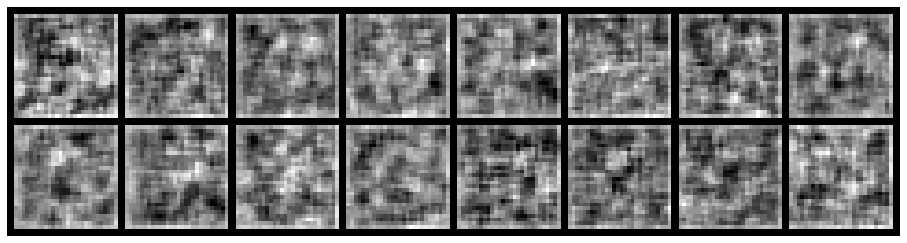

Epoch: [0/1], Batch Num: [0/600]
Discriminator Loss: 1.2388, Generator Loss: 0.7959
D(x): 0.5503, D(G(z)): 0.4692


KeyboardInterrupt: ignored

In [39]:
for epoch in range(num_epochs):
    for n_batch, (real_batch, _) in enumerate(data_loader):

        # 1. Train Discriminator
        # Generate fake data and noise

        real_data = Variable(images_to_vectors(real_batch)).type(dtype)      
        noise_vector = GANs_tools.noise(real_data.size(0), dtype)
        fake_data = generator(noise_vector).detach().type(dtype)

        # Train the Discriminator
        d_error, d_pred_real, d_pred_fake = GANs_tools.train_discriminator(d_optimizer,
                                                                           discriminator, loss,
                                                                           real_data, fake_data, dtype)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(GANs_tools.noise(real_batch.size(0), dtype))
        # Train Generator
        g_error = GANs_tools.train_generator(g_optimizer, discriminator, loss, fake_data, dtype)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)

        # Display Progress
        if (n_batch) % 100 == 0:
            clear_output(True)
            # Display Images
            test_noise = GANs_tools.noise(num_test_samples, dtype)
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches)
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
torch.cuda.is_available()

True

In [29]:
x = 'var'
def test():
  global dtype
  print(dtype)
test()

<class 'torch.cuda.FloatTensor'>
